In [1]:

from selective_recruitment.plotting import make_scatterplot
from selective_recruitment.scripts.script_mapwise import calc_ttest_mean
from selective_recruitment.scripts.script_roi_differences import norm_within_category # for results after normalization

import selective_recruitment.data as ss
import selective_recruitment.regress as ra
import selective_recruitment.region as sroi

from statsmodels.stats.anova import AnovaRM  # perform F test
from scipy.stats import ttest_rel

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

['/Users/lshahsha/Documents/GitHub/selective_recruitment/notebooks/Paper', '/Users/lshahsha/Documents/GitHub/selective_recruitment/notebooks/Paper', '/Users/lshahsha/Documents/GitHub', '/Users/lshahsha/Documents/GitHub/selective_recruitment', '/Users/lshahsha/Documents/GitHub/selective_recruitment/scripts', '/Users/lshahsha/Documents/GitHub/Functional_Fusion/Functional_Fusion', '/Users/lshahsha/Documents/GitHub/Functional_Fusion', '/Users/lshahsha/Documents/GitHub/cortico_cereb_connectivity', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/lshahsha/Documents/GitHub/selective_recruitment/.sr-venv/lib/python3.9/site-packages']


/Users/lshahsha/Documents/GitHub/selective_recruitment/.sr-venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# setting working directory
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'

# selective recruitment: ROI-based
scatterplots and statistical tests on the residuals for the selected region of interest

In [3]:
# setting up names and colors
label_dict = {1: 'Enc2F', 2: 'Ret2F',
              3: 'Enc2B', 4: 'Ret2B',
              5: 'Enc4F', 6: 'Ret4F',
              7: 'Enc4B', 8: 'Ret4B',
              9: 'Enc6F', 10: 'Ret6F',
              11: 'Enc6B', 12: 'Ret6B',
              13: 'rest'}
marker_dict = {1: 'o', 2: 'X',
               3: 'o', 4: 'X',
               5: 'o', 6: 'X',
               7: 'o', 8: 'X',
               9: 'o', 10: 'X',
               11: 'o', 12: 'X',
               13: 's'}
color_dict = {1: 'b', 2: 'b',
              3: 'r', 4: 'r',
              5: 'b', 6: 'b',
              7: 'r', 8: 'r',
              9: 'b', 10: 'b',
              11: 'r', 12: 'r',
              13: 'g'}

## Prepare the data for the scatterplot and the test

* Pick one parcellation: Here NettekovenSym32, a data-driven hierarchical symmetric parcellation. ROI will be selected from this parcellation.
* ss.get_summary_conn first uses a connectivity model to get predicted values for all the cerebellar voxels and then summarize the predicted values by averaging the values within the selected region of interest.


In [13]:
# get the summary df with observed and predicted activation within cerebellar parcels

## set params
dataset = "WMFS"
ses_id = 'ses-02'
parcellation = "NettekovenSym32"
cortex = "Icosahedron1002"
type = "CondHalf"
crossed = True
train_dataset = "MDTB"
train_ses_id = 'ses-s1'
method = "L2regression"
mname_base = f"{train_dataset}_{train_ses_id}_{cortex}_{method}"#f'Fusion_all_{cortex}_L2regression'
mname_ext = "_A8" # if you want to use the fused model, mname_ext will be fuse_id. Use "_A8" for the non-fused model
# # get predicted and observed within region of interest
# D = ss.get_summary_conn(dataset = dataset,
#                      ses_id = ses_id,
#                      subj = None, # to do all the subjects
#                      atlas_space = "SUIT3",
#                      cerebellum_roi = parcellation,
#                      cerebellum_roi_selected = None,
#                      cortex_roi = cortex,
#                      type = type,
#                      add_rest = True,
#                      mname_base = mname_base, # Fusion_all_Icosahedron1002_L2Regression_05_avg
#                      mname_ext = mname_ext,
#                      crossed = crossed)

# # apply regression to get residuals
# # this second regression is implemented because direct comparison of observed and 
# # predicted activation is not possible due to different scaling
# D = ra.roi_regress(D, fit_intercept=True)

# # # save the df
# D.to_csv(wkdir + f'/wm_ROI_{type}_{train_dataset}_{train_ses_id}_{method}{mname_ext}_reg.tsv', sep='\t')
D = pd.read_csv(wkdir + f'/wm_ROI_{type}_{train_dataset}_{train_ses_id}_{method}{mname_ext}_reg.tsv', sep='\t')

### Select region of interest.
Here we pick one parcel by first focusing on one network, the most relevant network: here the motor network. From the sub-regions within that network, we pick the one that shows consistently high activation throughout the task

In [14]:
roi_exp = "D.." # roi_exp = "D.?3.?R|D.?3.?L" # roi_exp = "D.?3.?R"
_, _, selected_ = sroi.get_parcel_single(parcellation = parcellation, 
                                               atlas_space = "SUIT3",
                                               roi_exp = roi_exp)
print(selected_)
table = pd.pivot_table(D.loc[np.isin(D.roi_name.values, selected_)], values='Y', index=['roi_name'], aggfunc=np.mean)
sorted_regions = table.sort_values(by=["Y"],ascending=False)
display(sorted_regions.T)
roi_selected = sorted_regions.T.columns[0]
print(f"selected region is {roi_selected}")


['D1L', 'D2L', 'D3L', 'D4L', 'D1R', 'D2R', 'D3R', 'D4R']


roi_name,D3R,D1R,D3L,D4R,D1L,D4L,D2R,D2L
Y,0.147329,0.115368,0.107958,0.087033,0.073267,0.064869,0.053291,0.038532


selected region is D3R


### make the scatterplot and test the residuals

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  2.2182 11.0000 165.0000 0.0157

                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
load               7.1009 2.0000 30.0000 0.0030
phase              0.3043 1.0000 15.0000 0.5893
recall             0.9495 1.0000 15.0000 0.3453
load:phase         4.3771 2.0000 30.0000 0.0215
load:recall        2.4205 2.0000 30.0000 0.1060
phase:recall       0.0679 1.0000 15.0000 0.7979
load:phase:recall  0.8296 2.0000 30.0000 0.4460



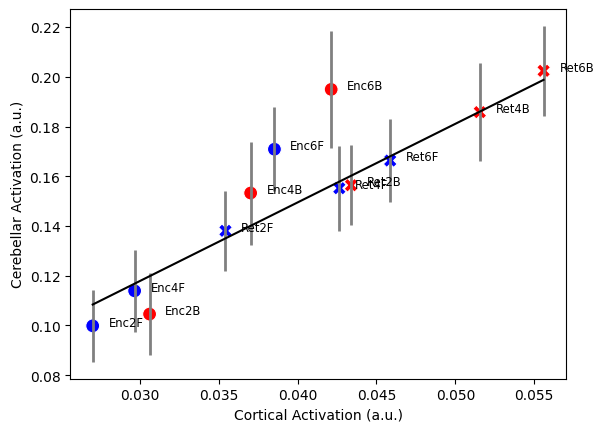

In [15]:
# get the dataframe with the selected region
selected_roi = "D3R"
df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
make_scatterplot(df, split='cond_num',
                labels=label_dict,
                markers=marker_dict,
                colors=color_dict)
# plt.xlabel("predicted cerebellar activation")
plt.savefig(f"wm_{selected_roi}_scatter_{mname_base}_{mname_ext}.pdf")
print(AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())
print(AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=["load", "phase", "recall"], aggregate_func=np.mean).fit())

In [16]:
print(df.R2.mean())
# calculate standard error per subject
df['se'] = df.groupby(['sn'])['res'].transform('sem')
df.se.mean()

0.4204744439220356


C:\Users\lshah\AppData\Local\Temp\ipykernel_14660\3730002815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['se'] = df.groupby(['sn'])['res'].transform('sem')


0.010484984847602555

In [12]:
## Make table with statistical values
mname = ['Fusion_all_L2regression_09',
        'MDTB_ses-s1_L2regression_A8',
        'MDTB_ses-s1_L1regression_A-5',
        'MDTB_all_L2regression_A8',
        'MDTB_all_L1regression_A-5']

# CondHalf_MDTB_ses-s1_L2regression_A8_reg
selected_roi = "D3R"
anova_tables = []
for m in mname:
    D = pd.read_csv(wkdir + f'/wm_ROI_CondHalf_{m}_reg.tsv', sep='\t')
    df = D.loc[(D.roi_name == selected_roi) & (D.cond_name != 'rest')]
    res = (AnovaRM(data=df[df.cond_name != 'rest'], depvar='res',subject='sn', within=['cond_name'], aggregate_func=np.mean).fit())
    res.anova_table['model'] = [m]
    anova_tables.append(res.anova_table)
anova_tables = pd.concat(anova_tables, axis=0)
print(anova_tables)

            F Value  Num DF  Den DF    Pr > F                         model
cond_name  2.549338    11.0   165.0  0.005294    Fusion_all_L2regression_09
cond_name  2.218169    11.0   165.0  0.015690   MDTB_ses-s1_L2regression_A8
cond_name  2.342188    11.0   165.0  0.010494  MDTB_ses-s1_L1regression_A-5
cond_name  2.562951    11.0   165.0  0.005058      MDTB_all_L2regression_A8
cond_name  2.342188    11.0   165.0  0.010494     MDTB_all_L1regression_A-5
